In [21]:
from google.colab import files
uploaded = files.upload()
import pandas as pd
df = pd.read_csv(next(iter(uploaded)))  # use uploaded CSV
df.head()


Saving Nitrate_With_Anomalies.csv to Nitrate_With_Anomalies (1).csv


,Distance_Downstream,Day,Nitrate_Concentration,Flow_Rate,Temperature,pH,is_safe,Anomaly
0,0.000000,1,6.149014,1.725886,18.415693,7.152303,0,0
1,20.202020,1,11.212567,1.733828,18.881455,7.090201,0,1
2,40.404040,1,5.522643,1.828606,17.860140,6.980282,0,0
3,60.606061,1,5.574961,1.599683,17.229390,6.983901,0,0
4,80.808081,1,5.041994,1.838621,17.637837,6.911993,0,0


In [22]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [23]:
# Prepare dataset for LSTM
df_sorted = df.sort_values(by=["Distance_Downstream", "Day"])
ts_df = df_sorted.groupby("Distance_Downstream").apply(lambda group: group.sort_values("Day")).reset_index(drop=True)

<ipython-input-23-e69298108ac3>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ts_df = df_sorted.groupby("Distance_Downstream").apply(lambda group: group.sort_values("Day")).reset_index(drop=True)


In [27]:
# Use one location for simple LSTM demo
site_id = df["Distance_Downstream"].unique()[0]  # or 500.0, 1000.0, etc.
one_site = df[df["Distance_Downstream"] == site_id]


features = ["Flow_Rate", "Temperature", "pH", "Nitrate_Concentration"]
scaler = MinMaxScaler()
data = scaler.fit_transform(one_site[features])

X, y = [], []
sequence_length = 3
for i in range(len(data) - sequence_length):
    X.append(data[i:i+sequence_length])
    y.append(data[i+sequence_length][3])  # Nitrate target

X = np.array(X)
y = np.array(y)

# LSTM Model
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=100, verbose=0)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 32)                  │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,309 (55.90 KB)

 Trainable params: 4,769 (18.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,540 (37.27 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


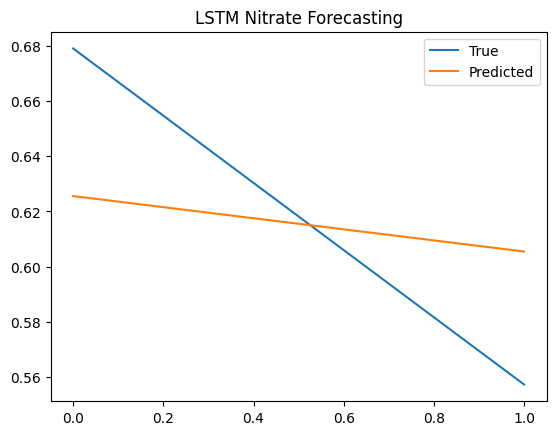

In [29]:
# Predict and plot
preds = model.predict(X)
y_pred = model.predict(X)

plt.plot(y, label='True')
plt.plot(preds, label='Predicted')
plt.title("LSTM Nitrate Forecasting")
plt.legend()
plt.show()


True Injected Anomalies: 5
Predicted Anomalies: 5


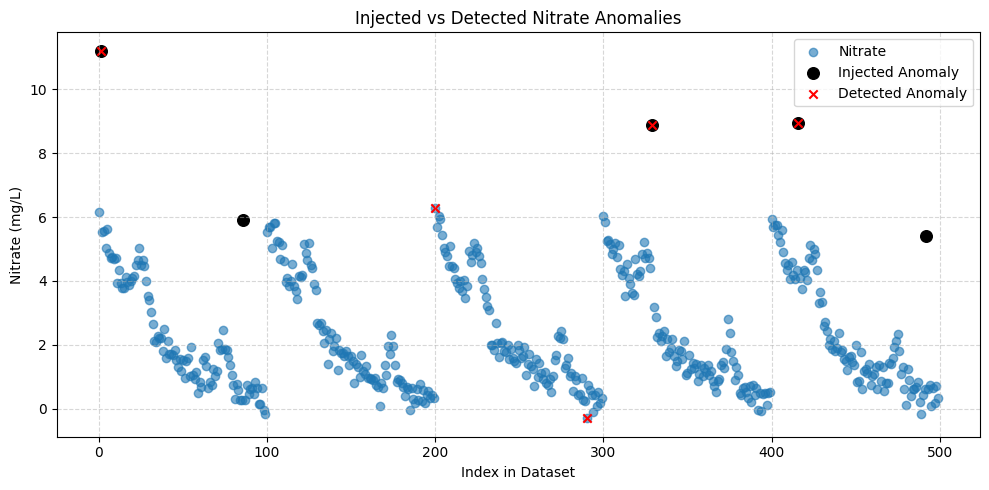

In [30]:
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt



# Run Isolation Forest on full dataset (not per-site)
model = IsolationForest(contamination=0.01, random_state=42)
df["Predicted_Anomaly"] = model.fit_predict(df[["Nitrate_Concentration"]])

# Convert to 0/1
df["Predicted_Anomaly"] = df["Predicted_Anomaly"].map({1: 0, -1: 1})

# How many actual vs predicted
true = df["Anomaly"].sum()
pred = df["Predicted_Anomaly"].sum()

print(f"True Injected Anomalies: {true}")
print(f"Predicted Anomalies: {pred}")

# Compare visually
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(df.index, df["Nitrate_Concentration"], label="Nitrate", alpha=0.6)
plt.scatter(df[df["Anomaly"] == 1].index, df[df["Anomaly"] == 1]["Nitrate_Concentration"], color="black", label="Injected Anomaly", s=70)
plt.scatter(df[df["Predicted_Anomaly"] == 1].index, df[df["Predicted_Anomaly"] == 1]["Nitrate_Concentration"], color="red", label="Detected Anomaly", marker="x")
plt.legend()
plt.title("Injected vs Detected Nitrate Anomalies")
plt.ylabel("Nitrate (mg/L)")
plt.xlabel("Index in Dataset")
plt.tight_layout()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

